In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from keras.utils.vis_utils import plot_model

print (tf.__version__)

2.9.2


In [ ]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [ ]:
# download the training images
(X_train, _), _ = keras.datasets.mnist.load_data()

# normalize pixel values
X_train = X_train.astype(np.float32) / 255

# reshape and rescale
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

BATCH_SIZE = 128

# create batches of tensors to be fed into the model
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
noise_input = 50

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[noise_input], 
                       activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),

    #First UpSample doubling the size to 14x14
    keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.BatchNormalization(),

    #Second UpSample doubling the size to 28x28
    keras.layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding="SAME",
                                 activation='tanh'),

    #keras.layers.Conv2D(1, (7,7), activation='tanh', padding='same')                              
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              319872    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                        

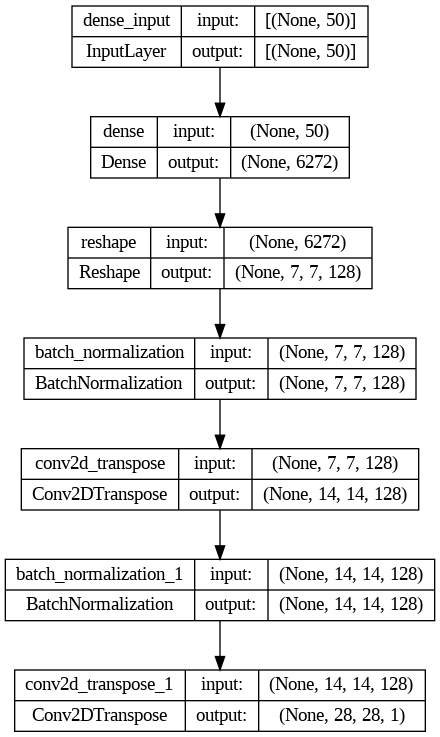

In [ ]:
plot_model(generator, show_shapes=True, 
           show_layer_names=True)

shape of the generated batch: (16, 28, 28, 1)


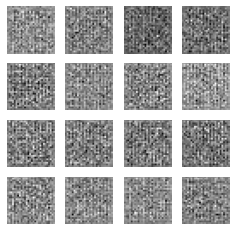

In [ ]:
# generate a batch of noise input (batch size = 16)
test_noise = tf.random.normal([16, noise_input])

# feed the batch to the untrained generator
test_image = generator(test_noise)

# visualize sample output
plot_results(test_image, n_cols=4)

print(f'shape of the generated batch: {test_image.shape}')

In [ ]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3137      
                                                                 
Total params: 41,729
Trainable params: 41,729
Non-trai

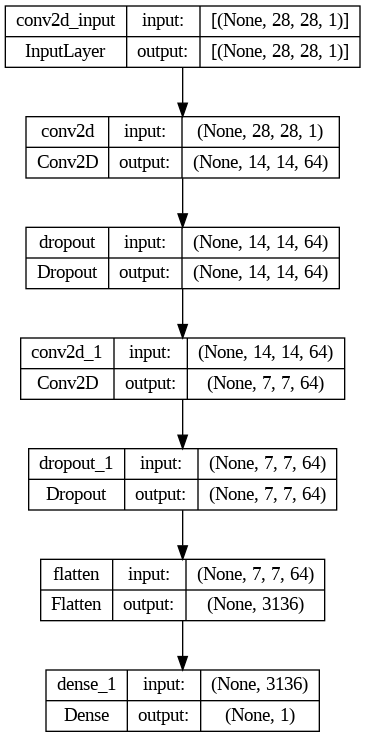

In [ ]:
plot_model(discriminator, show_shapes=True, 
           show_layer_names=True)

In [ ]:
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
#discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer=optimizer)

In [ ]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         585217    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 41729     
                                                                 
Total params: 626,946
Trainable params: 584,705
Non-trainable params: 42,241
_________________________________________________________________


In [ ]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # use the noise to generate fake images
            fake_images = generator(noise)

            # create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # ensure that the discriminator is trainable
            discriminator.trainable = True

            # use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            
            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]] * batch_size)

            # freeze the discriminator
            discriminator.trainable = False

            # train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
        
        # plot the fake images used to train the discriminator
        plot_results(fake_images, 8)                     
        plt.show()      

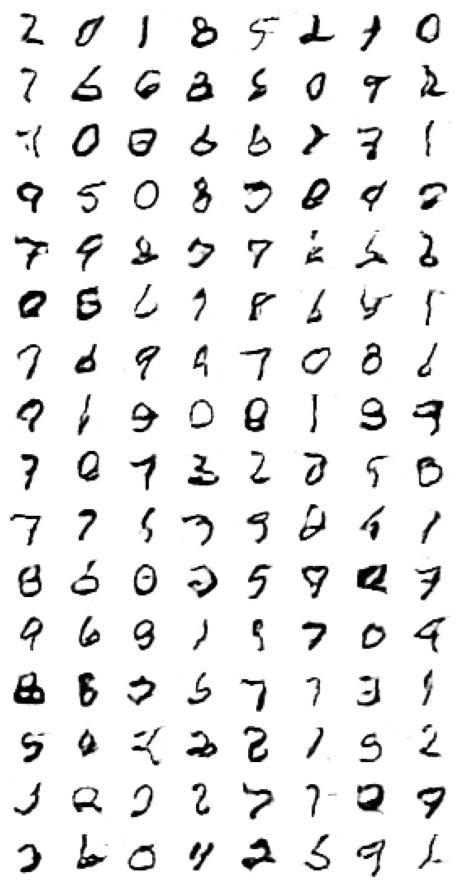

In [ ]:
train_gan(gan, dataset, noise_input, 30)